In [1]:
# Optional: setup NoTexBook theme
%load_ext notexbook
%texify -fs 18

**Adapted from**: [Ch6](https://github.com/uvm-plaid/programming-dp/blob/master/notebooks/ch6.ipynb)

# Approximate Differential Privacy


Approximate differential privacy, also called $(\epsilon, \delta)$-differential privacy, has the following definition:

\begin{align}
\mathsf{Pr}[F(x) = S] \leq e^\epsilon \mathsf{Pr}[F(x') = s] + \delta
\end{align}

The new privacy parameter, $\delta$, represents a "failure probability" for the definition. 

With probability $1-\delta$, we will get the same guarantee as pure differential privacy; with probability $\delta$, we get no guarantee. 

In other words:

- With probability $1-\delta$, $\frac{\mathsf{Pr}[F(x) = S]}{\mathsf{Pr}[F(x') = s]} \leq e^\epsilon$
- With probability $\delta$, we get no guarantee at all

This definition should seem a little bit scary! 

With probability $\delta$, anything at all could happen - including a release of the entire sensitive dataset! 

For this reason, we typically require $\delta$ to be very small - usually $\frac{1}{n^2}$ or less, where $n$ is the size of the dataset. 

In addition, it can be demonstrated in practice that the $(\epsilon, \delta)$-differentially private mechanisms in practical use 
don't fail catastrophically - as allowed by the definition - instead, they fail *gracefully*, and don't do terrible things like 
releasing the entire dataset.


Such mechanisms *are* possible, however, and they do satisfy the definition of $(\epsilon, \delta)$-differential privacy.

## Properties of Approximate Differential Privacy

Approximate differential privacy has similar properties to pure $\epsilon$-differential privacy. It satisfies **sequential composition**:

- If $F_1(x)$ satisfies $(\epsilon_1, \delta_1)$-differential privacy
- And $F_2(x)$ satisfies $(\epsilon_2, \delta_2)$-differential privacy
- Then the mechanism $G(x) = (F_1(x), F_2(x))$ which releases both results satisfies $(\epsilon_1+\epsilon_2, \delta_1 + \delta_2)$-differential privacy

The only difference from the pure $\epsilon$ setting is that we add up the values of $\delta$ as well as the values of $\epsilon$. 

Approximate differential privacy also satisfies **post-processing and parallel composition**.

## The Gaussian Mechanism

The Gaussian mechanism is an alternative to the Laplace mechanism, which adds Gaussian noise instead of Laplacian noise. 

The Gaussian mechanism does *not* satisfy pure $\epsilon$-differential privacy, but does satisfy $(\epsilon, \delta)$-differential 
privacy.

According to the Gaussian mechanism, for a function $f(x)$ which returns a number, the following definition of $F(x)$ satisfies $(\epsilon, \delta)$-differential privacy:

\begin{align}
F(x) = f(x) + \mathcal{N}(\sigma^2)\\
\text{where } \sigma^2 = \frac{2s^2 \log(1.25/\delta)}{\epsilon^2}
\end{align}

where $s$ is the sensitivity of $f$, and $\mathcal{N}(\sigma^2)$ denotes sampling from the Gaussian (normal) distribution with center 0 and variance $\sigma^2$. Note that here (and elsewhere in these notes), $\log$ denotes the natural logarithm.

For real-valued functions $f : D \rightarrow \mathbb{R}$, we can use the Gaussian mechanism in exactly the same way as we do the Laplace mechanism, and it's easy to compare what happens under both mechanisms for a given value of $\epsilon$.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

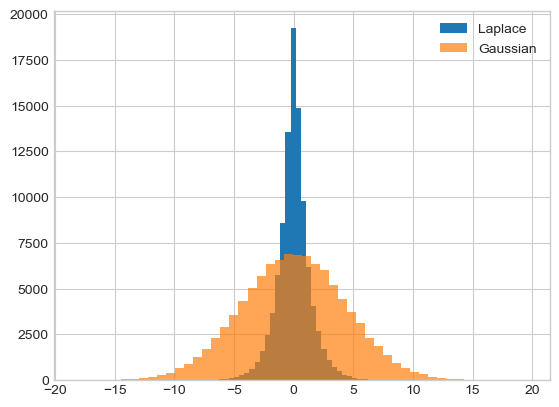

In [3]:
epsilon = 1
vals_laplace = [np.random.laplace(loc=0, scale=1/epsilon) for x in range(100000)]

delta = 10e-5
sigma = np.sqrt(2 * np.log(1.25 / delta)) * 1 / epsilon
vals_gauss = [np.random.normal(loc=0, scale=sigma) for x in range(100000)]

plt.hist(vals_laplace, bins=50, label='Laplace')
plt.hist(vals_gauss, bins=50, alpha=.7, label='Gaussian');
plt.legend();

Here, we graph the empirical probability density function of the Laplace and Gaussian mechanisms for $\epsilon = 1$, with $\delta = 10^{-5}$ for the Gaussian mechanism.

Compared to the Laplace mechanism, the plot for the Gaussian mechanism looks "squished." 

Differentially private outputs which are far from the true answer are much more likely using the Gaussian mechanism than they are under the Laplace mechanism (which, by comparison, looks extremely "pointy").

So the Gaussian mechanism has two **major drawbacks**:

1. it requires the use of the the relaxed $(\epsilon, \delta)$-differential privacy definition, *and* 
2. it's less accurate than the Laplace mechanism. 

Why would we want to use it?

## Vector-Valued Functions and their Sensitivities

So far, we have only considered real-valued functions (i.e. the function's output is always a single real number). 

Such functions are of the form $f : D \rightarrow \mathbb{R}$. 

Both the Laplace and Gaussian mechanism, however, can be extended to *vector-valued* functions of the form $f : D \rightarrow \mathbb{R}^k$, which return vectors of real numbers. 

We can think of histograms as vector-valued functions, which return a vector whose elements consist of histogram bin counts.

We saw earlier that the *sensitivity* of a function is:

\begin{align}
GS(f) = \max_{d(x,x') \leq 1} \lvert f(x) - f(x') \rvert
\end{align}

How do we define sensitivity for vector-valued functions?

Consider the expression $f(x) - f(x')$. 

If $f$ is a vector-valued function, then this expression represents the difference between two vectors, which can be computed as the difference between their corresponding elements (the difference of two length-$k$ vectors is thus a new length-$k$ vector). 

This new vector is the distance between $f(x)$ and $f(x')$, represented as a vector.

The magnitude of this vector is the sensitivity of $f$. 

There are several ways to compute the magnitude of a vector; we'll use two of them: the $L1$ norm and the $L2$ norm.

### L1 and L2 Norms

The $L1$ norm of a vector $V$ of length $k$ is defined as $\lVert V \rVert_1 = \sum_{i=1}^k \lvert V_i \rvert$ (i.e. it's the sum of the vector's elements). In 2-dimensional space, the $L1$ norm of the difference between two vectors yields the "manhattan distance" between them.

The $L2$ norm of a vector $V$ of length $k$ is defined as $\lVert V \rVert_2 = \sqrt{\sum_{i=1}^k V_i^2}$ (i.e. the square root of the sum of the squares). In 2-dimensional space, this is the "Euclidean distance", and it's always less than or equal to the $L1$ norm.

### L1 and L2 Sensitivities

The $L1$ sensitivity of a vector-valued function $f$ is:

\begin{align}
GS(f) = \max_{d(x,x') \leq 1} \lVert f(x) - f(x') \rVert_1
\end{align}

This is equal to the sum of the *elementwise* sensitivities. For example, if we define a vector-valued function $f$ that returns a length-$k$ vector of 1-sensitive results, then the $L1$ sensitivity of $f$ is $k$.

Similarly, the $L2$ sensitivity of a vector-valued function $f$ is:

\begin{align}
GS_2(f) = \max_{d(x,x') \leq 1} \lVert f(x) - f(x') \rVert_2
\end{align}

Using the same example as above, a vector-valued function $f$ returning a length-$k$ vector of 1-sensitive results has $L2$ sensitivity of $\sqrt{k}$. For long vectors, the $L2$ sensitivity will obviously be much lower than the $L1$ sensitivity! For some applications, like machine learning algorithms (which sometimes return vectors with thousands of elements), $L2$ sensitivity is *significantly* lower than $L1$ sensitivity.

### Choosing Between L1 and L2

As mentioned earlier, both the Laplace and Gaussian mechanisms can be extended to vector-valued functions. 

However, there's a key difference between these two extensions: 

- the vector-valued Laplace mechanism **requires** the use of $L1$ sensitivity, while the vector-valued Gaussian mechanism allows the use of either $L1$ or $L2$ sensitivity. 

This is a **major strength** of the Gaussian mechanism. For applications in which $L2$ sensitivity is much lower than $L1$ sensitivity, the Gaussian mechansim allows adding *much* less noise.

- The **vector-valued Laplace mechanism** releases $f(x) + (Y_1, \dots, Y_k)$, where $Y_i$ are drawn i.i.d. from the Laplace distribution with scale $\frac{s}{\epsilon}$ and $s$ is the $L1$ sensitivity of $f$

- The **vector-valued Gaussian mechanism** releases $f(x) + (Y_1, \dots, Y_k)$, where $Y_i$ are drawn i.i.d. from the Gaussian distribution with $\sigma^2 = \frac{2s^2 \log(1.25/\delta)}{\epsilon^2}$ and $s$ is the $L2$ sensitivity of $f$